# Battle of the Neighborhoods

In this notebook, we shall be analyzing the neighborhoods in Los Angeles(LA). We run all the code and resources needed to carry out our analysis.

We first import all the resources we need.

In [1]:
!pip install geopy

In [2]:
!pip install plotly

In [3]:
!pip install folium==0.5.0

In [4]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import geopy
from geopy.geocoders import Nominatim
import json
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import folium

# Neighborhoods in LA

In this section, we extract the regions, neighborhoods and postal codes from various sites. We then use arcgis to find the respective longitude and latitude values for each neighborhood.

## For Region-Zipcode Data

BeautifulSoup will be utilized to parse the html data.

In [5]:
url_region = 'https://www.usmapguide.com/california/los-angeles-zip-code-map/'
page_region = requests.get(url_region)
soup_region = BeautifulSoup(page_region.content, 'html5lib')
soup_region

<!DOCTYPE html>
<html lang="en-US"><head>
<meta charset="utf-8"/>
<meta content="View a list of all Los Angeles Zip Codes along with zip code map with an index of more than 220 different zip codes." name="description"/>
<meta content="los angeles ca zip code, zip code map" name="keywords"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<title>Los Angeles CA Zip Code Map [Updated 2020]</title>
<!-- Optimized by SG Optimizer plugin version - 5.7.17 -->
<!-- Social Warfare v4.2.1 https://warfareplugins.com - BEGINNING OF OUTPUT -->
<style>
	@font-face {
		font-family: "sw-icon-font";
		src:url("https://www.usmapguide.com/wp-content/plugins/social-warfare/assets/fonts/sw-icon-font.eot?ver=4.2.1");
		src:url("https://www.usmapguide.com/wp-content/plugins/social-warfare/assets/fonts/sw-icon-font.eot?ver=4.2.1#iefix") format("embedded-opentype"),
		url("https://www.usmapguide.com/wp-content/plugins/social-warfare/assets/fonts/sw-icon-font.woff?ver=4.2.1") format("woff"

With the html, we shall extract the the titles of the various regions labelled by headers h3.

In [60]:
reg = soup_region.find_all('h3', string=lambda text: 'zip codes' in text.lower())
reg_list = []
for x in reg:
    reg_list.append(str(x))
reg_list

['<h3 id="mce_0">GUIDE TO LOS ANGELES ZIP CODES AND NEIGHBORHOODS</h3>',
 '<h3>Northwest Country (Los Angeles) Zip Codes</h3>',
 '<h3>Antelope Valley (Los Angeles) Zip Codes</h3>',
 '<h3>Angeles Forest (Los Angeles) Zip Codes</h3>',
 '<h3>San Fernando Valley (Los Angeles) Zip Codes</h3>',
 '<h3>The Verdugos (Los Angeles) Zip Codes</h3>',
 '<h3>The San Gabriel Valley (Los Angeles) Zip Codes</h3>',
 '<h3>The Pomona Valley (Los Angeles) Zip Codes</h3>',
 '<h3>Northeast Los Angeles Zip Codes</h3>',
 '<h3>Central Los Angeles Zip Codes</h3>',
 '<h3>The Eastside (Los Angeles) Zip Codes</h3>',
 '<h3>The Westside (Los Angeles) Zip Codes</h3>',
 '<h3>South Los Angeles Zip Codes</h3>',
 '<h3>Southeast Los Angeles Zip Codes</h3>',
 '<h3>Santa Monica Mountains (Los Angeles) Zip Codes</h3>',
 '<h3>South Bay (Los Angeles) Zip Codes</h3>',
 '<h3>The Harbor (Los Angeles) Zip Codes</h3>']

We then find the text below each header for the zipcodes and assign them to a list.

In [7]:
zipcodes = []
for regions in reg:
    zipcodes.append(str(regions.find_next().text))
print(zipcodes)

['Below is an updated Los Angeles zip code map. Your complete guide to the Los Angeles area.', '91311, 91321, 91326, 91350, 91351, 91354, 91355, 91381, 91382, 91384, 91387, 91390, 93243, 93532, 93536.', '92397, 93510, 93523, 93534, 93535, 93536, 93543, 93544, 93550, 93551, 93552, 93553, 93591.', '91001, 91011, 91016, 91024, 91042, 91342, 91387, 91390, 91702, 91711, 91741, 91750, 91759, 92397, 93510, 93543, 93550, 93553, 93563.', '91040, 91304, 91306, 91307, 91311, 91316, 91324, 91325, 91326, 91330, 91331, 91335, 91340, 91342, 91343, 91344, 91345, 91352, 91356, 91364, 91367, 91401, 91402, 91403, 91405, 91406, 91411, 91423, 91436, 91501, 91502, 91504, 91505, 91506, 91522, 91523, 91601, 91602, 91604, 91605, 91606, 91608.', '91011, 91040, 91042, 91101, 91103, 91104, 91105, 91106, 91107, 91201, 91202, 91203, 91204, 91205, 91206, 91207, 91208, 91210, 91214.', '90601, 90602, 90603, 90605, 90631, 91006, 91007, 91008, 91010, 91016, 91024, 91030, 91108, 91702, 91706, 91722, 91723, 91724, 91731, 

In [8]:
reg_d = {'Region': reg_list, 'Zipcode': zipcodes}
reg_df = pd.DataFrame(reg_d)
reg_df

,Region,Zipcode
0,"<h3 id=""mce_0"">GUIDE TO LOS ANGELES ZIP CODES ...",Below is an updated Los Angeles zip code map. ...
1,<h3>Northwest Country (Los Angeles) Zip Codes<...,"91311, 91321, 91326, 91350, 91351, 91354, 9135..."
2,<h3>Antelope Valley (Los Angeles) Zip Codes</h3>,"92397, 93510, 93523, 93534, 93535, 93536, 9354..."
3,<h3>Angeles Forest (Los Angeles) Zip Codes</h3>,"91001, 91011, 91016, 91024, 91042, 91342, 9138..."
4,<h3>San Fernando Valley (Los Angeles) Zip Code...,"91040, 91304, 91306, 91307, 91311, 91316, 9132..."
5,<h3>The Verdugos (Los Angeles) Zip Codes</h3>,"91011, 91040, 91042, 91101, 91103, 91104, 9110..."
6,<h3>The San Gabriel Valley (Los Angeles) Zip C...,"90601, 90602, 90603, 90605, 90631, 91006, 9100..."
7,<h3>The Pomona Valley (Los Angeles) Zip Codes<...,"91711, 91750, 91766, 91767, 91768, 91773."
8,<h3>Northeast Los Angeles Zip Codes</h3>,"90031, 90032, 90041, 90042, 90065, 91204, 91205."
9,<h3>Central Los Angeles Zip Codes</h3>,"90004, 90005, 90006, 90012, 90013, 90014, 9001..."


From the dataset, we can see an unwanted title value is picked up, this shall be dropped.

In [9]:
reg_df.drop(labels=[0], axis=0, inplace=True)
reg_df

,Region,Zipcode
1,<h3>Northwest Country (Los Angeles) Zip Codes<...,"91311, 91321, 91326, 91350, 91351, 91354, 9135..."
2,<h3>Antelope Valley (Los Angeles) Zip Codes</h3>,"92397, 93510, 93523, 93534, 93535, 93536, 9354..."
3,<h3>Angeles Forest (Los Angeles) Zip Codes</h3>,"91001, 91011, 91016, 91024, 91042, 91342, 9138..."
4,<h3>San Fernando Valley (Los Angeles) Zip Code...,"91040, 91304, 91306, 91307, 91311, 91316, 9132..."
5,<h3>The Verdugos (Los Angeles) Zip Codes</h3>,"91011, 91040, 91042, 91101, 91103, 91104, 9110..."
6,<h3>The San Gabriel Valley (Los Angeles) Zip C...,"90601, 90602, 90603, 90605, 90631, 91006, 9100..."
7,<h3>The Pomona Valley (Los Angeles) Zip Codes<...,"91711, 91750, 91766, 91767, 91768, 91773."
8,<h3>Northeast Los Angeles Zip Codes</h3>,"90031, 90032, 90041, 90042, 90065, 91204, 91205."
9,<h3>Central Los Angeles Zip Codes</h3>,"90004, 90005, 90006, 90012, 90013, 90014, 9001..."
10,<h3>The Eastside (Los Angeles) Zip Codes</h3>,"90022, 90023, 90031, 90032, 90033, 90063."


The zipcodes separated by commas shall be split to facilitate analysis. The data will then be cleaned of whitespaces and unwanted characters.

In [10]:
reg_df2 = pd.concat([pd.Series(row['Region'], row['Zipcode'].split(','))              
                    for _, row in reg_df.iterrows()]).reset_index()

In [11]:
reg_df2.columns = ['Zipcode', 'Region']
reg_df2

,Zipcode,Region
0,91311,<h3>Northwest Country (Los Angeles) Zip Codes<...
1,91321,<h3>Northwest Country (Los Angeles) Zip Codes<...
2,91326,<h3>Northwest Country (Los Angeles) Zip Codes<...
3,91350,<h3>Northwest Country (Los Angeles) Zip Codes<...
4,91351,<h3>Northwest Country (Los Angeles) Zip Codes<...
...,...,...
310,90815,<h3>The Harbor (Los Angeles) Zip Codes</h3>
311,90822,<h3>The Harbor (Los Angeles) Zip Codes</h3>
312,90831,<h3>The Harbor (Los Angeles) Zip Codes</h3>
313,90840,<h3>The Harbor (Los Angeles) Zip Codes</h3>


In [12]:
reg_df2['n_Zipcode'] = reg_df2.Zipcode.astype('str')

In [13]:
reg_df2['n_Zipcode'] = reg_df2['n_Zipcode'].str.strip('.')
reg_df2['n_Zipcode'] = reg_df2['n_Zipcode'].str.strip(' ')
reg_df2

,Zipcode,Region,n_Zipcode
0,91311,<h3>Northwest Country (Los Angeles) Zip Codes<...,91311
1,91321,<h3>Northwest Country (Los Angeles) Zip Codes<...,91321
2,91326,<h3>Northwest Country (Los Angeles) Zip Codes<...,91326
3,91350,<h3>Northwest Country (Los Angeles) Zip Codes<...,91350
4,91351,<h3>Northwest Country (Los Angeles) Zip Codes<...,91351
...,...,...,...
310,90815,<h3>The Harbor (Los Angeles) Zip Codes</h3>,90815
311,90822,<h3>The Harbor (Los Angeles) Zip Codes</h3>,90822
312,90831,<h3>The Harbor (Los Angeles) Zip Codes</h3>,90831
313,90840,<h3>The Harbor (Los Angeles) Zip Codes</h3>,90840


In [14]:
reg_df2['n_Region'] = reg_df2.Region.astype('str')
reg_df2['n_Region'] = reg_df2['n_Region'].str.strip('<h3>')
reg_df2['n_Region'] = reg_df2['n_Region'].str.strip('</h3>')
reg_df2 = reg_df2.drop(['Zipcode', 'Region'], axis = 1)
reg_df2

,n_Zipcode,n_Region
0,91311,Northwest Country (Los Angeles) Zip Codes
1,91321,Northwest Country (Los Angeles) Zip Codes
2,91326,Northwest Country (Los Angeles) Zip Codes
3,91350,Northwest Country (Los Angeles) Zip Codes
4,91351,Northwest Country (Los Angeles) Zip Codes
...,...,...
310,90815,The Harbor (Los Angeles) Zip Codes
311,90822,The Harbor (Los Angeles) Zip Codes
312,90831,The Harbor (Los Angeles) Zip Codes
313,90840,The Harbor (Los Angeles) Zip Codes


In [15]:
reg_df2.columns = ['Zipcode', 'Region']
reg_df2

,Zipcode,Region
0,91311,Northwest Country (Los Angeles) Zip Codes
1,91321,Northwest Country (Los Angeles) Zip Codes
2,91326,Northwest Country (Los Angeles) Zip Codes
3,91350,Northwest Country (Los Angeles) Zip Codes
4,91351,Northwest Country (Los Angeles) Zip Codes
...,...,...
310,90815,The Harbor (Los Angeles) Zip Codes
311,90822,The Harbor (Los Angeles) Zip Codes
312,90831,The Harbor (Los Angeles) Zip Codes
313,90840,The Harbor (Los Angeles) Zip Codes


In [16]:
for zipc in reg_df2['Region']:
    reg_df2['Region'] = reg_df2['Region'].str.replace('Zip Codes', '')
reg_df2

,Zipcode,Region
0,91311,Northwest Country (Los Angeles)
1,91321,Northwest Country (Los Angeles)
2,91326,Northwest Country (Los Angeles)
3,91350,Northwest Country (Los Angeles)
4,91351,Northwest Country (Los Angeles)
...,...,...
310,90815,The Harbor (Los Angeles)
311,90822,The Harbor (Los Angeles)
312,90831,The Harbor (Los Angeles)
313,90840,The Harbor (Los Angeles)


In the below section, we drop duplicates as the source of the information has duplicates and may be inaccurate or have a system where duplicated zipcodes are used. For the purpose for this exercise, we do not include them.

In [17]:
reg_df2 = reg_df2.drop_duplicates(subset='Zipcode')
reg_df2

,Zipcode,Region
0,91311,Northwest Country (Los Angeles)
1,91321,Northwest Country (Los Angeles)
2,91326,Northwest Country (Los Angeles)
3,91350,Northwest Country (Los Angeles)
4,91351,Northwest Country (Los Angeles)
...,...,...
310,90815,The Harbor (Los Angeles)
311,90822,The Harbor (Los Angeles)
312,90831,The Harbor (Los Angeles)
313,90840,The Harbor (Los Angeles)


## For Neighborhood-Zipcode Data

This is the other set of data we require, postcodes for each neighborhood in each region. As the source site is a US postal site, PO boxes and some other data which we do not need is included, this shall be cleaned up later.

In [18]:
url_neigh = 'http://www.laalmanac.com/communications/cm02_communities.php'
page_neigh = requests.get(url_neigh)
soup_neigh = BeautifulSoup(page_neigh.content, 'html5lib')
soup_neigh

<!DOCTYPE html>
<html lang="en-US"><head>
      <!-- Global Site Tag (gtag.js) - Google Analytics -->
      <script async="" src="https://www.googletagmanager.com/gtag/js?id=GA_TRACKING_ID"></script>
      <script>
        window.dataLayer = window.dataLayer || [];
        function gtag(){dataLayer.push(arguments);}
        gtag('js', new Date());

        gtag('config', 'UA-31515633-1');
      </script>
      <meta charset="utf-8"/>
      <meta content="width=device-width, initial-scale=1.0" name="viewport"/>
      <title>Postal Zip Codes by Community in Los Angeles County, California</title>

      <meta content="Almanac facts, information and trivia about Los Angeles County, its people, cities and communities." name="description"/>
      <meta content="Los Angeles, Los Angeles County, almanac, Agoura Hills, Alhambra, Arcadia, Artesia, Avalon, Azusa, Baldwin Park, Bell, Bellflower, Bell Gardens, Beverly Hills, Bradbury, Burbank, Calabasas, Carson, Cerritos, Claremont, Commerce, Compt

In [19]:
neighlist = []
columns = ['Neighborhood', 'Zipcode']
df = pd.DataFrame(columns = columns)

for row in soup_neigh.find_all('tr')[1:]:
    data = row.find_all('td')
    row_data = [td.text for td in data]
    length = len(df)
    df.loc[length] = row_data
df

,Neighborhood,Zipcode
0,Acton,93510
1,Agoura Hills,91301
2,Agoura Hills (PO Boxes),91376
3,Agua Dulce,91390
4,Alhambra,"91801, 91803"
...,...,...
638,Winnetka (Los Angeles),91306
639,Winnetka (PO Boxes) (Los Angeles),91396
640,Woodland Hills (Los Angeles),"91364, 91367"
641,Woodland Hills (PO Boxes) (Los Angeles),"91365, 91372"


We drop the PO Boxes as they are post locations and we're not interested in them.

In [20]:
df_new = df[~df.Neighborhood.str.contains('PO Boxes')].reset_index(drop=True)
df_new

,Neighborhood,Zipcode
0,Acton,93510
1,Agoura Hills,91301
2,Agua Dulce,91390
3,Alhambra,"91801, 91803"
4,Alhambra (Non-Geographic Zip Code Within 91801),91804
...,...,...
504,Windsor Hills (Los Angeles),90043
505,Windsor Square (Los Angeles),"90004, 90005, 90010, 90020"
506,Winnetka (Los Angeles),91306
507,Woodland Hills (Los Angeles),"91364, 91367"


We then separate the comma separated values into individual rows

In [21]:
df_new2 = pd.concat([pd.Series(row['Neighborhood'], row['Zipcode'].split(','))              
                    for _, row in df_new.iterrows()]).reset_index()

In [22]:
df_new2.columns = ['Zipcode', 'Neighborhood']
df_new2['Zipcode'] = df_new2['Zipcode'].str.strip(' ')
df_new2

,Zipcode,Neighborhood
0,93510,Acton
1,91301,Agoura Hills
2,91390,Agua Dulce
3,91801,Alhambra
4,91803,Alhambra
...,...,...
750,90020,Windsor Square (Los Angeles)
751,91306,Winnetka (Los Angeles)
752,91364,Woodland Hills (Los Angeles)
753,91367,Woodland Hills (Los Angeles)


Once again, we drop duplicate zipcodes to weed out inaccuracies/inconsistancies for the purpose of this exercise.

In [23]:
df_new2 = df_new2.drop_duplicates(subset='Zipcode')
df_new2

,Zipcode,Neighborhood
0,93510,Acton
1,91301,Agoura Hills
2,91390,Agua Dulce
3,91801,Alhambra
4,91803,Alhambra
...,...,...
714,91792,West Covina
728,91361,Westlake Village
729,91362,Westlake Village
732,90602,Whittier


## Merged Dataset

We merge the 2 dataframes with Zipcode as the common column to match all the regions and neighborhoods to each other based on zipcode. As the sources are different, some data is lost as not all zipcodes in the 'Regions' df is has a value in the 'Neighborhood' and vice versa. We will also remove duplicates of neighborhoods after merging as we are only interested in 1 point per neighborhood.

In [24]:
LA_neigh = pd.merge(reg_df2, df_new2, on="Zipcode", how="inner")
LA_neigh

,Zipcode,Region,Neighborhood
0,91311,Northwest Country (Los Angeles),Chatsworth (Los Angeles)
1,91321,Northwest Country (Los Angeles),Newhall (Santa Clarita)
2,91326,Northwest Country (Los Angeles),Los Angeles (Northridge)
3,91350,Northwest Country (Los Angeles),Bouquet Canyon
4,91351,Northwest Country (Los Angeles),Canyon Country (Santa Clarita)
...,...,...,...
276,90815,The Harbor (Los Angeles),Long Beach
277,90822,The Harbor (Los Angeles),Long Beach
278,90831,The Harbor (Los Angeles),Long Beach (World Trade Center)
279,90840,The Harbor (Los Angeles),California State Univ Long Beach (Long Beach)


In [25]:
LA_neigh = LA_neigh.drop_duplicates(subset='Neighborhood')
LA_neigh

,Zipcode,Region,Neighborhood
0,91311,Northwest Country (Los Angeles),Chatsworth (Los Angeles)
1,91321,Northwest Country (Los Angeles),Newhall (Santa Clarita)
2,91326,Northwest Country (Los Angeles),Los Angeles (Northridge)
3,91350,Northwest Country (Los Angeles),Bouquet Canyon
4,91351,Northwest Country (Los Angeles),Canyon Country (Santa Clarita)
...,...,...,...
269,90805,The Harbor (Los Angeles),Long Beach (North Long Beach)
271,90807,The Harbor (Los Angeles),Bixby Knolls (Long Beach)
278,90831,The Harbor (Los Angeles),Long Beach (World Trade Center)
279,90840,The Harbor (Los Angeles),California State Univ Long Beach (Long Beach)


## Geographical Co-ordinates

In this section, the geographic co-ordinates will be fetched via arcgis. The function defined below fetches the data from arcgis.

In [26]:
!pip install arcgis
from arcgis.geocoding import geocode
from arcgis.gis import GIS
gis = GIS()
def get_coord(add1):
    longi = 0
    lati = 0
    g = geocode(address='{}, LA, California, USA'.format(add1))[0]
    longi = g['location']['x']
    lati = g['location']['y']
    return str(lati) +","+ str(longi)

We fetch the latitudes and longitudes based on the zipcodes from our dataset.

In [27]:
coords = []
for zipcode in LA_neigh['Zipcode']:
    coords.append(get_coord(zipcode))

coords

['34.24428500000005,-118.58597999999995',
 '34.381335000000036,-118.53003999999999',
 '34.269265000000075,-118.54840999999999',
 '34.44731060000004,-118.51256279999996',
 '34.42006010000006,-118.46667029999998',
 '34.44072860000006,-118.55041529999994',
 '34.38518920000007,-118.57658319999996',
 '34.49269000000004,-118.62201999999996',
 '34.49227500000006,-118.33201999999994',
 '34.66160970000004,-118.39200519999997',
 '34.68509130000007,-118.18104629999999',
 '34.46937430000003,-118.20080219999994',
 '34.92409040000007,-117.9375523',
 '34.69489000000004,-118.14158999999995',
 '34.68277500000005,-118.10117499999996',
 '34.52105000000006,-117.99431499999997',
 '34.46950500000003,-117.84496499999995',
 '34.57701000000003,-118.11423999999994',
 '34.587330000000065,-118.15428499999996',
 '34.56792500000006,-118.03962999999999',
 '34.18563000000006,-118.13386999999994',
 '34.20511000000005,-118.20060499999994',
 '34.14477500000004,-118.00279999999998',
 '34.164300000000026,-118.058714999999

In [28]:
LA_neigh['Coord'] = coords
LA_neigh

<ipython-input-28-9125aa4e0fe4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LA_neigh['Coord'] = coords


,Zipcode,Region,Neighborhood,Coord
0,91311,Northwest Country (Los Angeles),Chatsworth (Los Angeles),"34.24428500000005,-118.58597999999995"
1,91321,Northwest Country (Los Angeles),Newhall (Santa Clarita),"34.381335000000036,-118.53003999999999"
2,91326,Northwest Country (Los Angeles),Los Angeles (Northridge),"34.269265000000075,-118.54840999999999"
3,91350,Northwest Country (Los Angeles),Bouquet Canyon,"34.44731060000004,-118.51256279999996"
4,91351,Northwest Country (Los Angeles),Canyon Country (Santa Clarita),"34.42006010000006,-118.46667029999998"
...,...,...,...,...
269,90805,The Harbor (Los Angeles),Long Beach (North Long Beach),"33.85147000000006,-118.18981499999995"
271,90807,The Harbor (Los Angeles),Bixby Knolls (Long Beach),"33.832610000000045,-118.18281499999995"
278,90831,The Harbor (Los Angeles),Long Beach (World Trade Center),"33.767660000000035,-118.19939"
279,90840,The Harbor (Los Angeles),California State Univ Long Beach (Long Beach),"33.77532500600006,-118.11814576899997"


In [29]:
LA_neigh[['Latitude','Longitude']] = LA_neigh.Coord.str.split(",",expand=True,)
LA_neigh

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Zipcode,Region,Neighborhood,Coord,Latitude,Longitude
0,91311,Northwest Country (Los Angeles),Chatsworth (Los Angeles),"34.24428500000005,-118.58597999999995",34.24428500000005,-118.58597999999995
1,91321,Northwest Country (Los Angeles),Newhall (Santa Clarita),"34.381335000000036,-118.53003999999999",34.381335000000036,-118.53003999999999
2,91326,Northwest Country (Los Angeles),Los Angeles (Northridge),"34.269265000000075,-118.54840999999999",34.269265000000075,-118.54840999999999
3,91350,Northwest Country (Los Angeles),Bouquet Canyon,"34.44731060000004,-118.51256279999996",34.44731060000004,-118.51256279999996
4,91351,Northwest Country (Los Angeles),Canyon Country (Santa Clarita),"34.42006010000006,-118.46667029999998",34.42006010000006,-118.46667029999998
...,...,...,...,...,...,...
269,90805,The Harbor (Los Angeles),Long Beach (North Long Beach),"33.85147000000006,-118.18981499999995",33.85147000000006,-118.18981499999995
271,90807,The Harbor (Los Angeles),Bixby Knolls (Long Beach),"33.832610000000045,-118.18281499999995",33.832610000000045,-118.18281499999995
278,90831,The Harbor (Los Angeles),Long Beach (World Trade Center),"33.767660000000035,-118.19939",33.767660000000035,-118.19939
279,90840,The Harbor (Los Angeles),California State Univ Long Beach (Long Beach),"33.77532500600006,-118.11814576899997",33.77532500600006,-118.11814576899997


In [30]:
LA_neigh['Latitude'] = LA_neigh['Latitude'].str.strip(' ')
LA_neigh['Longitude'] = LA_neigh['Longitude'].str.strip(' ')
LA_neigh = LA_neigh.drop(['Coord'], axis = 1)
LA_neigh

<ipython-input-30-d93e04e08179>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LA_neigh['Latitude'] = LA_neigh['Latitude'].str.strip(' ')
<ipython-input-30-d93e04e08179>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LA_neigh['Longitude'] = LA_neigh['Longitude'].str.strip(' ')


,Zipcode,Region,Neighborhood,Latitude,Longitude
0,91311,Northwest Country (Los Angeles),Chatsworth (Los Angeles),34.24428500000005,-118.58597999999995
1,91321,Northwest Country (Los Angeles),Newhall (Santa Clarita),34.381335000000036,-118.53003999999999
2,91326,Northwest Country (Los Angeles),Los Angeles (Northridge),34.269265000000075,-118.54840999999999
3,91350,Northwest Country (Los Angeles),Bouquet Canyon,34.44731060000004,-118.51256279999996
4,91351,Northwest Country (Los Angeles),Canyon Country (Santa Clarita),34.42006010000006,-118.46667029999998
...,...,...,...,...,...
269,90805,The Harbor (Los Angeles),Long Beach (North Long Beach),33.85147000000006,-118.18981499999995
271,90807,The Harbor (Los Angeles),Bixby Knolls (Long Beach),33.832610000000045,-118.18281499999995
278,90831,The Harbor (Los Angeles),Long Beach (World Trade Center),33.767660000000035,-118.19939
279,90840,The Harbor (Los Angeles),California State Univ Long Beach (Long Beach),33.77532500600006,-118.11814576899997


In [31]:
LA_neigh[["Latitude", "Longitude"]] = LA_neigh[["Latitude", "Longitude"]].apply(pd.to_numeric)

In [32]:
LA_neigh.dtypes

Zipcode          object
Region           object
Neighborhood     object
Latitude        float64
Longitude       float64
dtype: object

The dataframe to work with is now complete! Now we shall visualise these neighborhoods on the map of LA.

## Visualizing the Neighborhood

In this section, we use folium to visualise the data and neighborhoods we have.

In [33]:
g = geocode(address='Los Angeles, California, USA')[0]
LA_longi = g['location']['x']
LA_lati = g['location']['y']
print(LA_longi, ',', LA_lati)

-118.24544999999995 , 34.053570000000036


In [34]:
# create map of LA using latitude and longitude values
map_LA = folium.Map(location=[LA_lati, LA_longi], zoom_start=10)

# add markers to map
for lat, lng, region, neighborhood in zip(LA_neigh['Latitude'], LA_neigh['Longitude'], LA_neigh['Region'], LA_neigh['Neighborhood']):
    label = '{}, {}'.format(neighborhood, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  

map_LA

# Venue information

For this section, to extract the venue information, we shall be utilizing foursquare API

In [35]:
CLIENT_ID = 'UUAFENKXCX3JGT5VPZINO5SNAEHVJUG1GA2BRFPNA1TBDGLU'
CLIENT_SECRET = 'YKMUK23UXRYLDKKZJJ0E1EK3ZPD1QTTW5ASPFJ3SGJ1ZSYKQ'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

We shall iterate fetching the venue information once as an example.

In [36]:
neighborhood_latitude = LA_neigh.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = LA_neigh.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = LA_neigh.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Chatsworth (Los Angeles) are 34.24428500000005, -118.58597999999996.


In [37]:
#determining foursquare callback url
LIMIT = 100
radius = 500
url4sq = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

url4sq

'https://api.foursquare.com/v2/venues/explore?&client_id=UUAFENKXCX3JGT5VPZINO5SNAEHVJUG1GA2BRFPNA1TBDGLU&client_secret=YKMUK23UXRYLDKKZJJ0E1EK3ZPD1QTTW5ASPFJ3SGJ1ZSYKQ&v=20180605&ll=34.24428500000005,-118.58597999999996&radius=500&limit=100'

In [38]:
results = requests.get(url4sq).json()
results

{'meta': {'code': 200, 'requestId': '60d9ef10453f00347ea006a7'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Chatsworth',
  'headerFullLocation': 'Chatsworth, Los Angeles',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 1,
  'suggestedBounds': {'ne': {'lat': 34.24878500450005,
    'lng': -118.58054647329548},
   'sw': {'lat': 34.239784995500045, 'lng': -118.59141352670444}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bb4c2686ebfc9b6ae51edfa',
       'name': 'ampm',
       'location': {'address': '9500 De Soto Ave,',
        'lat': 34.243135,
        'lng': -118.588072,
        'labeledLatLngs': [{'label': 'display',
   

In [39]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [61]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,ampm,Convenience Store,34.243135,-118.588072


Now that it works, we shall do it for all the neighborhoods.

In [62]:
#function to repeat the process for all neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url4sq = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url4sq).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [42]:
#fetch data
LA_neigh_venues = getNearbyVenues(names=LA_neigh['Neighborhood'],
                                   latitudes=LA_neigh['Latitude'],
                                   longitudes=LA_neigh['Longitude']
                                  )

Chatsworth (Los Angeles)
Newhall (Santa Clarita)
Los Angeles (Northridge)
Bouquet Canyon
Canyon Country (Santa Clarita)
Santa Clarita
Stevenson Ranch
Castaic
Agua Dulce
Elizabeth Lake
Del Sur
Acton
Edwards AFB (Portion in LA County)
Lancaster
Hi Vista
Juniper Hills
Crystalaire
Lake Los Angeles
City Ranch
Palmdale
Altadena
La Cañada Flintridge
Monrovia
Sierra Madre
Los Angeles (Tujunga)
Kagel Canyon
Azusa
Claremont
Glendora
La Verne
Mount Baldy (Portion in LA County)
Pearblossom
Los Angeles (Shadow Hills)
Box Canyon
Los Angeles (Winnetka)
Bell Canyon
Encino (Los Angeles)
California State Univ Northridge (Los Angeles)
Arleta (Los Angeles)
Los Angeles (Reseda)
Los Angeles (Mission Hills)
Los Angeles (North Hills)
Granada Hills (Los Angeles)
La Tuna Canyon (Los Angeles)
Los Angeles (Tarzana)
Los Angeles (Woodland Hills)
Los Angeles (Valley Glen)
Los Angeles (Panorama City)
Los Angeles (Sherman Oaks)
Lake Balboa (Los Angeles)
Los Angeles (Van Nuys)
Burbank
Burbank (Glenoaks)
Burbank (Burban

In [43]:
#check dataframe for returned values
print(LA_neigh_venues.shape)
LA_neigh_venues.head()

(4353, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chatsworth (Los Angeles),34.244285,-118.58598,ampm,34.243135,-118.588072,Convenience Store
1,Newhall (Santa Clarita),34.381335,-118.53004,Egg Plantation,34.380392,-118.530654,Breakfast Spot
2,Newhall (Santa Clarita),34.381335,-118.53004,El Taco Llama,34.380512,-118.529055,Mexican Restaurant
3,Newhall (Santa Clarita),34.381335,-118.53004,Honu Coffee House,34.380478,-118.531299,Café
4,Newhall (Santa Clarita),34.381335,-118.53004,El Trocadero Mesquite Steakhouse,34.378576,-118.527545,Mexican Restaurant


In [63]:
LA_neigh_venues.isna().sum() #check for NA values during the fetch

Neighborhood              0
Neighborhood Latitude     0
Neighborhood Longitude    0
Venue                     0
Venue Latitude            0
Venue Longitude           0
Venue Category            0
dtype: int64

In [45]:
#check how many venues returned for each neighborhood
LA_neigh_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Acton,6,6,6,6,6,6
Agoura Hills,24,24,24,24,24,24
Alhambra,45,45,45,45,45,45
Altadena,16,16,16,16,16,16
Americana at Brand & Glendale Galleria (Glendale),56,56,56,56,56,56
...,...,...,...,...,...,...
Universal City,100,100,100,100,100,100
Veterans Administration,28,28,28,28,28,28
West Covina,38,38,38,38,38,38


In [46]:
print('There are {} uniques categories.'.format(len(LA_neigh_venues['Venue Category'].unique())))

There are 326 uniques categories.


In [47]:
# one hot encoding
LA_onehot = pd.get_dummies(LA_neigh_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
LA_onehot['Neighborhood'] = LA_neigh_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [LA_onehot.columns[-1]] + list(LA_onehot.columns[:-1])
LA_onehot = LA_onehot[fixed_columns]

LA_onehot

,Yoga Studio,ATM,Accessories Store,Advertising Agency,Airport Service,American Restaurant,Andhra Restaurant,Antique Shop,Arcade,Argentinian Restaurant,...,Vegetarian / Vegan Restaurant,Veterans' Organization,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4351,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
LA_onehot.shape

(4353, 326)

In [49]:
LA_grouped = LA_onehot.groupby('Neighborhood').mean().reset_index()
LA_grouped

,Neighborhood,Yoga Studio,ATM,Accessories Store,Advertising Agency,Airport Service,American Restaurant,Andhra Restaurant,Antique Shop,Arcade,...,Vegetarian / Vegan Restaurant,Veterans' Organization,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Acton,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,Agoura Hills,0.0,0.041667,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,Alhambra,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.022222,0.000000,0.000000,0.0,0.022222,0.0,0.022222,0.0
3,Altadena,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.062500,0.000000,0.0,0.000000,0.0,0.000000,0.0
4,Americana at Brand & Glendale Galleria (Glendale),0.0,0.000000,0.017857,0.0,0.0,0.017857,0.0,0.0,0.0,...,0.0,0.0,0.017857,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,Universal City,0.0,0.000000,0.000000,0.0,0.0,0.020000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
185,Veterans Administration,0.0,0.000000,0.000000,0.0,0.0,0.071429,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.035714,0.000000,0.0,0.000000,0.0,0.000000,0.0
186,West Covina,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.026316,0.105263,0.0,0.000000,0.0,0.000000,0.0
187,Westlake Village,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [50]:
#to find each neighbourhood and the top 5 most available amenities
num_top_venues = 5

for hood in LA_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = LA_grouped[LA_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Acton----
           venue  freq
0  Grocery Store  0.33
1           Café  0.17
2           Food  0.17
3      Pet Store  0.17
4           Park  0.17


----Agoura Hills----
                  venue  freq
0  Fast Food Restaurant  0.08
1                  Park  0.04
2   Fried Chicken Joint  0.04
3        Shipping Store  0.04
4           Pizza Place  0.04


----Alhambra----
               venue  freq
0             Bakery  0.07
1       Burger Joint  0.04
2               Café  0.04
3               Bank  0.04
4  Mobile Phone Shop  0.04


----Altadena----
                  venue  freq
0         Grocery Store  0.12
1  Fast Food Restaurant  0.06
2        Hardware Store  0.06
3        Sandwich Place  0.06
4                  Bank  0.06


----Americana at Brand & Glendale Galleria (Glendale)----
                  venue  freq
0        Sandwich Place  0.05
1        Cosmetics Shop  0.05
2      Toy / Game Store  0.04
3  Fast Food Restaurant  0.04
4       Thai Restaurant  0.04


----Arcadia----
       

In [51]:
#function to sort venue
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
# to display top 10 common amenities for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = LA_grouped['Neighborhood']

for ind in np.arange(LA_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(LA_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acton,Grocery Store,Café,Food,Pet Store,Park,Notary,North Indian Restaurant,Noodle House,Nightlife Spot,Nightclub
1,Agoura Hills,Fast Food Restaurant,Park,Fried Chicken Joint,Shipping Store,Pizza Place,Gas Station,Breakfast Spot,Sports Bar,Mexican Restaurant,Chinese Restaurant
2,Alhambra,Bakery,Burger Joint,Café,Bank,Mobile Phone Shop,Mexican Restaurant,Rental Car Location,Bookstore,Coffee Shop,Sushi Restaurant
3,Altadena,Grocery Store,Fast Food Restaurant,Hardware Store,Sandwich Place,Bank,Scenic Lookout,Coffee Shop,Thrift / Vintage Store,Mexican Restaurant,Food Truck
4,Americana at Brand & Glendale Galleria (Glendale),Sandwich Place,Cosmetics Shop,Toy / Game Store,Fast Food Restaurant,Thai Restaurant,Clothing Store,Ice Cream Shop,Sporting Goods Shop,Pizza Place,Shopping Plaza
...,...,...,...,...,...,...,...,...,...,...,...
184,Universal City,Theme Park Ride / Attraction,Theme Park,Coffee Shop,Fast Food Restaurant,Clothing Store,Gift Shop,Hotel,Candy Store,New American Restaurant,Beer Bar
185,Veterans Administration,Italian Restaurant,Gym,American Restaurant,Coffee Shop,Sushi Restaurant,Massage Studio,Cocktail Bar,Health Food Store,Café,Construction & Landscaping
186,West Covina,Vietnamese Restaurant,Indonesian Restaurant,Bubble Tea Shop,Noodle House,Asian Restaurant,Sandwich Place,Mexican Restaurant,Salad Place,Malay Restaurant,Grocery Store
187,Westlake Village,Pool,Yoga Studio,Nail Salon,Office,Notary,North Indian Restaurant,Noodle House,Nightlife Spot,Nightclub,New American Restaurant


## K-means Clustering

We use sihoulette score to find the optimum K to be used for our KMeans Clustering.

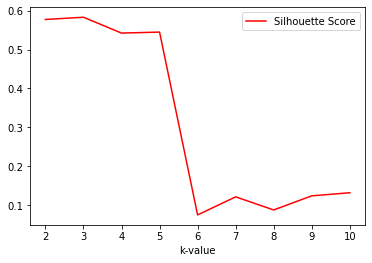

In [53]:
from sklearn.metrics import silhouette_score

LA_grouped_clustering = LA_grouped.drop('Neighborhood', 1)

sil = []
kmax = 10

# minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k, n_init=25, random_state=42, max_iter=600).fit(LA_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(LA_grouped_clustering, labels, metric='euclidean'))

K_num = list(range(2, kmax+1))
sil_df = pd.DataFrame(list(zip(K_num, sil)), columns =['k-value', 'Silhouette Score'])
sil_df.plot(kind='line',x='k-value',y='Silhouette Score',color='red')
plt.show()

From the graph, we can see the peak is at k=3, thus we choose it.

In [54]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, n_init=25, random_state=42, max_iter=600).fit(LA_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [55]:
#DataFrame to include cluster and top 10 neighborhoods
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


# merge toronto_grouped with geo_merge to add latitude/longitude for each neighborhood
LA_merged = pd.merge(LA_neigh, neighborhoods_venues_sorted, on='Neighborhood')
LA_merged # check the last columns!

,Zipcode,Region,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,91311,Northwest Country (Los Angeles),Chatsworth (Los Angeles),34.244285,-118.585980,1,Convenience Store,Yoga Studio,Nail Salon,Optical Shop,Office,Notary,North Indian Restaurant,Noodle House,Nightlife Spot,Nightclub
1,91321,Northwest Country (Los Angeles),Newhall (Santa Clarita),34.381335,-118.530040,0,Mexican Restaurant,Diner,Breakfast Spot,Clothing Store,Market,Grocery Store,Liquor Store,Hobby Shop,Theater,Bakery
2,91350,Northwest Country (Los Angeles),Bouquet Canyon,34.447311,-118.512563,0,Mexican Restaurant,Tanning Salon,Grocery Store,Bakery,Sandwich Place,Video Store,Breakfast Spot,Coffee Shop,Salon / Barbershop,Dry Cleaner
3,91351,Northwest Country (Los Angeles),Canyon Country (Santa Clarita),34.420060,-118.466670,0,Fast Food Restaurant,Arts & Crafts Store,Greek Restaurant,Mexican Restaurant,Ice Cream Shop,Thrift / Vintage Store,Home Service,New American Restaurant,Notary,North Indian Restaurant
4,91354,Northwest Country (Los Angeles),Santa Clarita,34.440729,-118.550415,0,Pool,Convenience Store,Pharmacy,Nightlife Spot,Bus Station,Flea Market,Park,Yoga Studio,New American Restaurant,Notary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,90805,The Harbor (Los Angeles),Long Beach (North Long Beach),33.851470,-118.189815,0,Bakery,Video Store,Fried Chicken Joint,Food Truck,Coffee Shop,Discount Store,Burger Joint,Pet Store,Pharmacy,Notary
185,90807,The Harbor (Los Angeles),Bixby Knolls (Long Beach),33.832610,-118.182815,0,Mexican Restaurant,Clothing Store,Pizza Place,American Restaurant,Brewery,Ramen Restaurant,Coffee Shop,Theater,Thai Restaurant,Bank
186,90831,The Harbor (Los Angeles),Long Beach (World Trade Center),33.767660,-118.199390,0,Sandwich Place,Coffee Shop,Gym / Fitness Center,Deli / Bodega,Food,BBQ Joint,Breakfast Spot,Hotel,American Restaurant,Pizza Place
187,90840,The Harbor (Los Angeles),California State Univ Long Beach (Long Beach),33.775325,-118.118146,0,Coffee Shop,Sushi Restaurant,Ice Cream Shop,Café,Bubble Tea Shop,Shipping Store,Supplement Shop,Big Box Store,Fast Food Restaurant,Hawaiian Restaurant


In [65]:
#visualize clusters

# create map
map_clusters = folium.Map(location=[LA_lati, LA_longi], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(LA_merged['Latitude'], LA_merged['Longitude'], LA_merged['Neighborhood'], LA_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [57]:
LA_merged.loc[LA_merged['Cluster Labels'] == 0, LA_merged.columns[[2] + list(range(5, LA_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Newhall (Santa Clarita),0,Mexican Restaurant,Diner,Breakfast Spot,Clothing Store,Market,Grocery Store,Liquor Store,Hobby Shop,Theater,Bakery
2,Bouquet Canyon,0,Mexican Restaurant,Tanning Salon,Grocery Store,Bakery,Sandwich Place,Video Store,Breakfast Spot,Coffee Shop,Salon / Barbershop,Dry Cleaner
3,Canyon Country (Santa Clarita),0,Fast Food Restaurant,Arts & Crafts Store,Greek Restaurant,Mexican Restaurant,Ice Cream Shop,Thrift / Vintage Store,Home Service,New American Restaurant,Notary,North Indian Restaurant
4,Santa Clarita,0,Pool,Convenience Store,Pharmacy,Nightlife Spot,Bus Station,Flea Market,Park,Yoga Studio,New American Restaurant,Notary
5,Stevenson Ranch,0,Department Store,Bridal Shop,Martial Arts School,Sushi Restaurant,Bank,Bakery,BBQ Joint,Supermarket,Shipping Store,Donut Shop
...,...,...,...,...,...,...,...,...,...,...,...,...
184,Long Beach (North Long Beach),0,Bakery,Video Store,Fried Chicken Joint,Food Truck,Coffee Shop,Discount Store,Burger Joint,Pet Store,Pharmacy,Notary
185,Bixby Knolls (Long Beach),0,Mexican Restaurant,Clothing Store,Pizza Place,American Restaurant,Brewery,Ramen Restaurant,Coffee Shop,Theater,Thai Restaurant,Bank
186,Long Beach (World Trade Center),0,Sandwich Place,Coffee Shop,Gym / Fitness Center,Deli / Bodega,Food,BBQ Joint,Breakfast Spot,Hotel,American Restaurant,Pizza Place
187,California State Univ Long Beach (Long Beach),0,Coffee Shop,Sushi Restaurant,Ice Cream Shop,Café,Bubble Tea Shop,Shipping Store,Supplement Shop,Big Box Store,Fast Food Restaurant,Hawaiian Restaurant


In [58]:
LA_merged.loc[LA_merged['Cluster Labels'] == 1, LA_merged.columns[[2] + list(range(5, LA_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chatsworth (Los Angeles),1,Convenience Store,Yoga Studio,Nail Salon,Optical Shop,Office,Notary,North Indian Restaurant,Noodle House,Nightlife Spot,Nightclub
23,Kagel Canyon,1,Convenience Store,Yoga Studio,Nail Salon,Optical Shop,Office,Notary,North Indian Restaurant,Noodle House,Nightlife Spot,Nightclub


In [59]:
LA_merged.loc[LA_merged['Cluster Labels'] == 2, LA_merged.columns[[2] + list(range(5, LA_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,City Ranch,2,Grocery Store,Optical Shop,Office,Notary,North Indian Restaurant,Noodle House,Nightlife Spot,Nightclub,New American Restaurant,Nail Salon
126,"Florence-Graham, South Los Angeles (Los Angeles)",2,Grocery Store,Optical Shop,Office,Notary,North Indian Restaurant,Noodle House,Nightlife Spot,Nightclub,New American Restaurant,Nail Salon
